# Invasive Species Monitoring
https://www.kaggle.com/c/invasive-species-monitoring


## 1. Problem/data description
The data set contains pictures taken in a Brazilian national forest. In some of the pictures there is Hydrangea, a beautiful invasive species original of Asia. Based on the training pictures and the labels provided, the participant should predict the presence of the invasive species in the testing set of pictures.

In [1]:
import os
import pickle

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

tf.set_random_seed(777)  # for reproducibility
img_width, img_height = [128, 128]

In [2]:
labels = pd.read_csv('input/train_labels.csv')
print(labels.head())

   name  invasive
0     1         0
1     2         0
2     3         1
3     4         0
4     5         1


Height:866 Width:1154


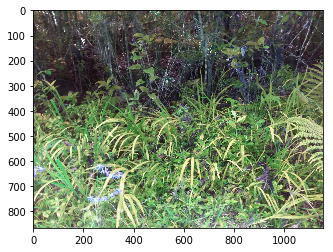

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  

img = cv2.imread('input/train/1.jpg')
print('Height:{0} Width:{1}'.format(img.shape[0], img.shape[1]))
plt.imshow(img)

Height:866 Width:1154


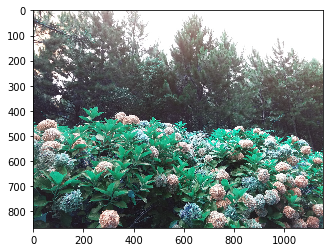

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  

img = cv2.imread('input/train/5.jpg')
print('Height:{0} Width:{1}'.format(img.shape[0], img.shape[1]))
plt.imshow(img)

## 2. Loading data

In [5]:
def load_train():
    x_imgs = []
    labels = pd.read_csv('input/train_labels.csv')
    
    for name in labels['name']:
        img = cv2.imread('input/train/{}.jpg'.format(name))
        img = cv2.resize(img, (img_width, img_height))
        x_imgs.append(img)
    
    x = np.array(x_imgs) / 255
    y = labels['invasive']
    
    return x, y

In [6]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file, protocol=4)
        file.close()
    else:
        print("Directory doesn't exists")

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [5]:
x_train, y_train = load_train()

In [6]:
cache_data(x_train, './x_train.dump')
cache_data(y_train, './y_train.dump')

In [7]:
x_train = restore_data('./x_train.dump')
y_train = restore_data('./y_train.dump')

In [8]:
x_train.shape

(2295, 128, 128, 3)

In [9]:
y_train.shape

(2295,)

In [11]:
y_train = y_train.reshape([2295, 1])
y_train.shape

(2295, 1)

## 3. Model
Model implementation. It can be divided to several small sections.

In [12]:
class Model(object):
    def __init__(self, sess, lr=0.001):
        self.sess = sess
        self.lr = lr
        self.build_model()
        self.sess.run(tf.global_variables_initializer())

    def build_model(self):
        self.X = tf.placeholder(shape=[None, 128, 128, 3], dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
        self.dropout = tf.placeholder(dtype=tf.float32)

        filt1_1 = tf.Variable(tf.random_normal([3, 3, 3, 32], stddev=0.01))
        filt1_2 = tf.Variable(tf.random_normal([3, 3, 32, 32], stddev=0.01))

        filt2_1 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
        filt2_2 = tf.Variable(tf.random_normal([3, 3, 64, 64], stddev=0.01))

        filt3_1 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
        filt3_2 = tf.Variable(tf.random_normal([3, 3, 128, 128], stddev=0.01))

        filt4_1 = tf.Variable(tf.random_normal([3, 3, 128, 256], stddev=0.01))
        filt4_2 = tf.Variable(tf.random_normal([3, 3, 256, 256], stddev=0.01))

        fc_W1 = tf.Variable(tf.random_normal([8 * 8 * 256, 512], stddev=0.01))
        fc_W2 = tf.Variable(tf.random_normal([512, 1], stddev=0.01))

        scale = tf.Variable(tf.ones([3]))
        beta = tf.Variable(tf.zeros([3]))
        batch_mean, batch_var = tf.nn.moments(self.X, [0])
        self.X_bn = tf.nn.batch_normalization(self.X, batch_mean, batch_var, beta, scale, 1e-3)

        self.conv1_1 = tf.nn.relu(tf.nn.conv2d(self.X_bn, filt1_1, strides=[1, 1, 1, 1], padding='SAME'))
        self.conv1_2 = tf.nn.relu(tf.nn.conv2d(self.conv1_1, filt1_2, strides=[1, 1, 1, 1], padding='SAME'))
        self.pool1 = tf.nn.max_pool(self.conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.conv2_1 = tf.nn.relu(tf.nn.conv2d(self.pool1, filt2_1, strides=[1, 1, 1, 1], padding='SAME'))
        self.conv2_2 = tf.nn.relu(tf.nn.conv2d(self.conv2_1, filt2_2, strides=[1, 1, 1, 1], padding='SAME'))
        self.pool2 = tf.nn.max_pool(self.conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.conv3_1 = tf.nn.relu(tf.nn.conv2d(self.pool2, filt3_1, strides=[1, 1, 1, 1], padding='SAME'))
        self.conv3_2 = tf.nn.relu(tf.nn.conv2d(self.conv3_1, filt3_2, strides=[1, 1, 1, 1], padding='SAME'))
        self.pool3 = tf.nn.max_pool(self.conv3_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.conv3_1 = tf.nn.relu(tf.nn.conv2d(self.pool2, filt3_1, strides=[1, 1, 1, 1], padding='SAME'))
        self.conv3_2 = tf.nn.relu(tf.nn.conv2d(self.conv3_1, filt3_2, strides=[1, 1, 1, 1], padding='SAME'))
        self.pool3 = tf.nn.max_pool(self.conv3_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.conv4_1 = tf.nn.relu(tf.nn.conv2d(self.pool3, filt4_1, strides=[1, 1, 1, 1], padding='SAME'))
        self.conv4_2 = tf.nn.relu(tf.nn.conv2d(self.conv4_1, filt4_2, strides=[1, 1, 1, 1], padding='SAME'))
        self.pool4 = tf.nn.max_pool(self.conv4_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.fc1 = tf.reshape(self.pool4, [-1, fc_W1.get_shape().as_list()[0]])
        self.fc1 = tf.nn.relu(tf.matmul(self.fc1, fc_W1))
        self.fc1 = tf.nn.dropout(self.fc1, self.dropout)

        scale1 = tf.Variable(tf.ones([512]))
        beta1 = tf.Variable(tf.zeros([512]))
        batch_mean1, batch_var1 = tf.nn.moments(self.fc1, [0])
        self.fc1_bn = tf.nn.batch_normalization(self.fc1, batch_mean1, batch_var1, beta1, scale1, 1e-3)

        self.fc2 = tf.matmul(self.fc1_bn, fc_W2)
        self.pred = tf.nn.sigmoid(self.fc2)
        
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.Y, logits=self.fc2))
        self.train = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.cost)

        correct_pred = tf.equal(self.pred > 0.5, self.Y > 0.5)
        self.acc = tf.reduce_mean(tf.cast(correct_pred, "float"))

    def fit(self, X, Y, epochs=10, batch_size=128, dropout=0.5):
        for epoch in range(epochs):
            avg_cost = 0
            avg_acc = 0

            for step in range(0, len(X), batch_size):
                batch_mask = np.random.choice(len(X), batch_size) # For dataset shuffle

                feed_dict = {self.X: X[batch_mask],
                             self.Y: Y[batch_mask], self.dropout: dropout}

                _, c , a= self.sess.run([self.train, self.cost, self.acc], feed_dict=feed_dict)
                avg_cost += c
                avg_acc += a

            avg_cost = avg_cost / (len(X) / batch_size)
            avg_acc = avg_acc / (len(X) / batch_size)
            print("epoch: {} cost: {:.5f} acc: {:.5f}".format(epoch, avg_cost, avg_acc))
        print("Optimization Finished!")

    def pred_data(self, X, batch_size=128):
        preds = []
        for step in tqdm(range(0, len(X), batch_size)):
            feed_dict = {self.X: X[step:step+batch_size],
                         self.dropout: 1}

            pred_batch = self.sess.run(self.pred, feed_dict=feed_dict)

            for pred in pred_batch:
                preds.append(pred)

        return preds

    def save_model(self, path):
        saver = tf.train.Saver()
        saver.save(self.sess, os.path.join(path, 'model.ckpt'))

    def restore_model(self, path):
        saver = tf.train.Saver()

        ckpt = tf.train.get_checkpoint_state(path)

        if ckpt and ckpt.model_checkpoint_path:
            print('load learning')
            saver.restore(self.sess, ckpt.model_checkpoint_path)

In [13]:
sess = tf.Session()
model = Model(sess)
model.fit(x_train, y_train, epochs=30)

epoch: 0 cost: 0.63020 acc: 0.66362
epoch: 1 cost: 0.51711 acc: 0.75556
epoch: 2 cost: 0.44018 acc: 0.80915
epoch: 3 cost: 0.38789 acc: 0.82963
epoch: 4 cost: 0.35041 acc: 0.85577
epoch: 5 cost: 0.26651 acc: 0.89499
epoch: 6 cost: 0.22083 acc: 0.92549
epoch: 7 cost: 0.19363 acc: 0.93072
epoch: 8 cost: 0.18226 acc: 0.93551
epoch: 9 cost: 0.16016 acc: 0.95033
epoch: 10 cost: 0.15435 acc: 0.94989
epoch: 11 cost: 0.15460 acc: 0.94728
epoch: 12 cost: 0.15041 acc: 0.95033
epoch: 13 cost: 0.10156 acc: 0.97081
epoch: 14 cost: 0.08944 acc: 0.97691
epoch: 15 cost: 0.08848 acc: 0.97124
epoch: 16 cost: 0.10830 acc: 0.96819
epoch: 17 cost: 0.10041 acc: 0.97211
epoch: 18 cost: 0.10833 acc: 0.96906
epoch: 19 cost: 0.08902 acc: 0.97298
epoch: 20 cost: 0.06956 acc: 0.98257
epoch: 21 cost: 0.06028 acc: 0.98562
epoch: 22 cost: 0.06793 acc: 0.98301
epoch: 23 cost: 0.08205 acc: 0.97298
epoch: 24 cost: 0.07879 acc: 0.97255
epoch: 25 cost: 0.04839 acc: 0.99085
epoch: 26 cost: 0.04219 acc: 0.99041
epoch: 27 c

In [14]:
model.save_model('weight')

## 4. Results
Show the result

In [15]:
def load_test():
    x_imgs = []
    labels = pd.read_csv('input/sample_submission.csv')
    
    for name in labels['name']:
        img = cv2.imread('input/test/{}.jpg'.format(name))
        img = cv2.resize(img, (128, 128))
        x_imgs.append(img)
    
    x = np.array(x_imgs) / 255

    return x

In [16]:
x_test = load_test()

In [17]:
pred_arr = model.pred_data(x_test)

100%|██████████| 12/12 [00:45<00:00,  3.85s/it]


In [18]:
pred_arr = np.array(pred_arr)
pred_arr.shape

(1531, 1)

In [19]:
df_test = pd.read_csv('input/sample_submission.csv')
df_test['invasive'] = pred_arr
df_test.to_csv('submission.csv', index=False)

## 5. Future work/exercises

use pre-train model - vgg16 
https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98

Increase image size

data augmentation